###  Multinomial Logistic Regression - Soft Max Regression
#### Using Newton-Raphson Method : Quasi-Newton Methods
#### Notebook Author: Nirupam Purushothama

#### Referred Books & Links:
1. Machine Learning - A Probabilistic Perspective - Kevin P. Murphy
2. Pattern Recognition and Machine Learning - Christopher M. Bishop
3. Hands-on Machine Learning with Scikit-Learn & TensorFlow - Aurelien Geron
4. [Online - Lecture1](http://www.stat.cmu.edu/~ryantibs/convexopt-S15/lectures/14-newton.pdf)
5. [Online - Lecture2](https://www.stat.cmu.edu/~ryantibs/convexopt/lectures/quasi-newton.pdf)
6. [BFGS - Wiki](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)
7. [Quasi-Newton - Wiki](https://en.wikipedia.org/wiki/Quasi-Newton_method)
8. [Backtracking Line Search - Wiki](https://en.wikipedia.org/wiki/Backtracking_line_search)

Despite this effort, I expect bugs/errors to be present. You are more than welcome to report them. Will be happy to fix them. This is not intended to be reusable library code. It is just for academic/learning purposes. The reason why this had to be bridged from so many sources is because none of the locations had a clear description of the algorithm to directly translate that into code. Hence, had to glean it from multiple sources.

This notebook doesn't use Sci-kit learn's funciton but codes the Newton Raphson method. So, for those interested in the internal details of descending a Multinomial Regression's Negative Likelihood Function to find the final set of parameters check the code below

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline 

In [2]:
train_df = pd.read_csv("./training.csv")
d_max = train_df.shape[1]

x = np.array(train_df.iloc[:,1:d_max])
y = np.array(train_df.iloc[:,0])

# To adjust for the code below
y = y -1

#### 1. The softmax score function is defined below:
The function calculate_mu computes the estimated probability that x belongs to class k

In [3]:
# Multinomial logistic regression
# theta_lcl - D X C matrix
# x_lcl - N x D matrix
# returns Mu - N x C Matrix
# Where c = #Categories, D = #Features
def calculate_mu(x_lcl, theta_lcl):
    
    # Calculate the score function
    scores = np.matmul(x_lcl,theta_lcl)
    
    # Convert to a manageable range
    min_l = np.min(scores)
    max_l = np.max(scores)
    o_range = max_l - min_l
    n_range = 600
    
    scores = (scores - min_l) * n_range / o_range
    
    exps = np.exp(scores)
    #exps = np.abs(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [4]:
# Returns a y_hot which is a N x C matrix
def to_one_hot(y):
    n_classes = y.max()+1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    
    return Y_one_hot

In [5]:
y_train_one_hot = to_one_hot(y)

#### 1.2. Writing the function that reports the accuracy of predictions

In [6]:
def check_accuracy(the):
    test_df = pd.read_csv("./testing.csv")
    d_max = test_df.shape[1]
    x_t = np.array(test_df.iloc[:,1:d_max])
    y_t = np.array(test_df.iloc[:,0])

    # To adjust for the code below
    y_t = y_t -1

    x_t.shape[1]


    m =  x_t.shape[0] # number of data points

    # Add a bias to each of the rows (i.e. a constant)
    x_t_b = np.c_[np.ones((m,1)),x_t]


    logs = x_t_b.dot(the)
    Y_proba = calculate_mu(x_t_b, the)
    y_predict = np.argmax(Y_proba, axis=1)

    accuracy_score = np.mean(y_predict == y_t)
    return accuracy_score

#### 2. Gradient Calculation

g(W) = ∇f(w) = $\sum_{i=1}^{N}(μ_i - y_i) ⊗ x_i$

Where 
* w = $\theta$
* μ = prob that this point belongs to category (notations differ between textbooks)
* n = m = i = data point (notations differ between textbooks)
* $\varphi$ = x 
* I = Identity matrix
* y = the y_hot vector we defined above

⊗ is [Kronecker Product](https://en.wikipedia.org/wiki/Kronecker_product)

In [7]:
# Returns a CD x 1 vector 
# mu_lcl - N x C Matrix
# y_lcl - N x C Matrix - y_hot matrix
# x_lcl - N x D matrix
# Where c = #Categories, D = #Features
def gradient(mu_lcl, y_lcl, x_lcl):
    # The N rows
    N = x_lcl.shape[0]
    # C Categories
    C = mu_lcl.shape[1]
    # D Dimensions
    D = x_lcl.shape[1]
    
    g = np.zeros((C*D,1))
    
    for i in range(N):
        diff = mu_lcl[i:i+1] - y_lcl[i:i+1]

        # diff.T is a C x 1 vector and x[i:i+1].T is a D x 1 vector
        # resultant cron multiplication is a CD x 1 vector
        kron_result = np.kron(diff.T,x_lcl[i:i+1].T)
        
        g = g + kron_result
        
    return g   

#### 3. Direct Hessian Computation
Considered two text books and both had different notations. Hence summarizing the notations as follows:

Books referred were:
Pattern Recognition and Machine Learning - Bishop &

Machine Learning - A Probabilistic Perspective - Murphy

Hessian is given by 
$∇w_k∇w_j  E(w_1, . . . ,w_K)$ = $−\sum_{n=1}^{N}$ $y_n^k$ $(I_k^j - y_n^j)$ $φ_nφ_n^T$

##### Writing this in a condensed format this is will be 

H(W) = $∇^2 f(w) = \sum_{i=1}^{N}(diag(μ_i) − μ_iμ_i^T) ⊗ (x_i x_i^T)$

Where 
* w = $\theta$
* μ = prob that this point belongs to category (notations differ between textbooks)
* n = m = i = data point (notations differ between textbooks)
* $\varphi$ = x 
* I = Identity matrix

⊗ is Kronecker Product 

In [8]:
# Mu is a N x C Matrix
# x is a N x D Matrix
# Hessian is a CD x CD Matrix
def hessian(mu, x):
    # The N rows
    N = x.shape[0]
    
    C = mu.shape[1]
    D = x.shape[1]
    
    # size of hessian is C*D X C*D [Where c = #Categories, D = #Features]
    h = np.zeros((C*D,C*D))
    
    # i is the ith data point
    for i in range(N):
        
        # d_mu_i is a C x C Matrix
        d_mu_i = np.diagflat(mu[i])

        # mu_sq C x C Matrix
        # Here for us the array is provided as a row vector and hence we do array.T * array.         
        # whereas in the definition above it is vector * vector.T . Notice that difference
        mu_sq = np.matmul(mu[i:i+1].T, mu[i:i+1])
    
        # xi_sq is a D x D Matrix
        xi_sq = np.matmul(x[i:i+1].T, x[i:i+1])
        
        # Kron-result is a CD x CD Matrix
        kron_result = np.kron((d_mu_i - mu_sq),xi_sq)
        
        # Summate across all data points
        h = h + kron_result
        
    return h

#### 4. Quasi-Newton (Metric) Methods - Hessian and Inverse Calculation

<b>Reference: Machine Learning - A probabilistic perspective - Murphy</b>

Sometimes H goes into singularities leading to no progress in the algorithm. And also H may be too expensive to compute. Quasi-Newton methods iteratively build up an approximation to the Hessian using information gleaned
from the gradient vector at each step. The most common method is called BFGS (named after its inventors, Broyden, Fletcher, Goldfarb and Shanno), which updates the approximation to the Hessian $B_k ≈ H_k$ as follows:

$B_{k+1} = B_k + y_ky_k^T/(y_k^T s_k) − (B_ks_k)(B_ks_k)^T/(s_k^T B_k s_k)$

$s_k = θ_k − θ_{k−1}$

$y_k = g_k − g_{k−1}$

(Refer below for more details on why this notation is incorrect)

This is a rank-two update to the matrix, and ensures that the matrix remains positive definite (under certain restrictions on the step size). We typically start with a diagonal approximation, $B_0 = I$. Thus BFGS can be thought of as a “diagonal plus low-rank” approximation to the Hessian.

Alternatively, BFGS can iteratively update an approximation to the inverse Hessian, $C_k ≈ H_k^{−1}$, as follows:

$C_{k+1} = (I − s_ky_k^T/(y_k^Ts_k))$ $C_k$ $(I − y_ks^T_k/(y^T_k s_k))$ + $s_ks^T_k/(y^T_k s_k)$

<b>Note: Corrections</b>
Text-book has a mistake. With the above notation we will not be able to start the algorithm. Wikipedia has a better mention of the algorithm. [BFGS - Algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) [Quasi-Newton Method](https://en.wikipedia.org/wiki/Quasi-Newton_method#Description_of_the_method)

Both of these links mention:

$s_k = θ_{k+1} − θ_k$

$y_k = g_{k+1} − g_k$

In [9]:
#Definitions:
# yk is a CD x 1 vector. And yk_transpose is a 1 X CD vector
# thk is a D x C vector and when we unravel the theta it should be thk.T.ravel() 
# because gradient is listed C1(D1, D2...) and C2 (D1,..) etc. and if we need to get the same order from theta 
# then we need to unravel the transpose of the gradient vectors. Finally sk is a CD x 1 matrix

# Gradients is a CD x 1 vector 
# theta is a D x C vector
# returns a CD x CD matrix
def quasi_hessian(bk, gk, gk_1, thk, thk_1):
    
    yk = gk_1 - gk
    
    # ravel gives us a row vector. We will convert that to a column vector
    sk = ((thk_1 - thk).T.reshape(1,cd_size)).T
    
    return bk + np.matmul(yk,yk.T)/np.matmul(yk.T,sk) - np.matmul(np.matmul(bk,sk),np.matmul(bk,sk).T) / np.matmul(np.matmul(sk.T,bk),sk)

# returns a CD x CD matrix
def quasi_hess_inv(ck, gk, gk_1, thk, thk_1):
    
    cd_size = gk.shape[0]
    
    idt = np.identity(gk.shape[0])
    yk = gk_1 - gk
    # ravel gives us a row vector. We will convert that to a column vector
    # sk = ((thk_1 - thk).T.ravel()).T
    sk = ((thk_1 - thk).T.reshape(1,cd_size)).T
    
    part0 = np.matmul(yk.T,sk)
    part1 = idt - (np.matmul(sk,yk.T)/part0)
    part2 = idt - (np.matmul(yk,sk.T)/part0)
    part3 = np.matmul(sk, sk.T)/part0
    
    return np.matmul(np.matmul(part1,ck),part2) + part3

####  5. Newton Raphson Method

About the method and its working details

From the textbook:

Set $w_C$ = 0, to ensure identifiability, and define w = vec(W(:, 1 : C−1)) to be a D×(C−1) column vector. Therefore we set $\theta_c$ to 0

Newton’s method
Algorithm 8.1: Newton’s method for minimizing a strictly convex function
1. Initialize $θ_0$;
2. for k = 1, 2, . . . until convergence do
3. Evaluate $g_k = ∇f(θ_k)$;
4. Evaluate $H_k = ∇^2f(θ_k)$;
5. Solve $H_kd_k = −g_k$ for $d_k$;
6. Use line search to find stepsize $η_k$ along $d_k$;
7. $θ_(k+1)$ = $θ_k + η_kd_k$;

#### 4.1. Method 1 - Implementation by Calculating Hessian and Inverse directly

This hits singularity and stops and hence there is no learning. The reason the code doesn't throw singularity error is because of floating point calculations and very minute errors in the inverse calculation (but it hits a singularity. You can check this with a smaller dataset)

0.4


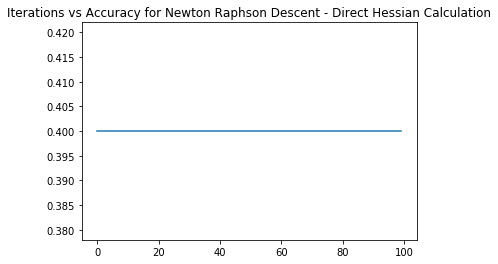

In [10]:
alpha =  0.01 # Learning rate as identified by eta-k in the above definition

n_iterations = 100
m =  x.shape[0] # number of data points
n = x.shape[1] # number of features
epsilon = 100
delta = 0.001
accu = []

# Add a bias to each of the rows (i.e. a constant)
x_b = np.c_[np.ones((m,1)),x]

# Take a random theta to begin the run
np.random.seed(13)
theta = np.random.randn(n + 1,y.max()+1)

for i in range(n_iterations):

    mu = calculate_mu(x_b,theta)

    gradients = gradient(mu, y_train_one_hot, x_b)  
    hess = hessian(mu,x_b)
    
    step = np.matmul(np.linalg.inv(hess),gradients)
    
    step = step / (np.max(step)/10)

    # Step is a CD x 1 Matrix. It is [C1[D1,D2..,Dn], C2[D1,D2,...,Dn]...]. Reshape the CD X 1 matrix to D X C
    # Hence the reshape will be C x D will make it to unravel the results as required
    # And then we need to add this as a D x C matrix to theta and hence we transpose it
    theta = theta + alpha * step.reshape(y.max()+1, n+1).T
    
    accu.append(check_accuracy(theta))

plt.plot(range(n_iterations),accu)
plt.title('Iterations vs Accuracy for Newton Raphson Descent - Direct Hessian Calculation')
check_accuracy(theta)
    
print(check_accuracy(theta))

#### 4.2. Choose the step with Backtracking line search
Alpha value keeps changing as we initiate theta with some random values initally and they change in every run.

[About the method - Wikipedia](https://en.wikipedia.org/wiki/Backtracking_line_search)

<img src="./backtrackinglinesearch.png" height="600" width="700"/>


f(θ) = J(θ) = Cross Entropy Cost Function. It is given by 

J(θ) = −1/m $\sum_{i=1}^{m}$ $\sum_{k=1}^{K}$ $y_k^{(i)}$ log ($\hat{p}_k^{(i)}$)

Where 
* m is the number of data points
* K is the number of categories
* $y_k^{(i)}$ is equal to 1 if the target class for the ith instance is k; otherwise it is equal to 0

f(θ) = -L(θ) where L(θ) is the Log-likelihood. So, f(θ) is nothing but the negative log-likelihood. It is not difficult to see why the likelihood is the given sum. We maximize the log-likelihood i.e. L(θ) and hence we will try to minimize f(θ). L(θ) proceeds from the assumption that each of the labels is independent and from there computing the probablity is pretty straight forward. You can refer Machine Learning - A Probabilistic Perspective - Murphy for more details.

In this case I ignore the 1/m factor and compute the J(θ). 

In [11]:
# f(theta) is here the Cross entropy cost function which is implemented here. 
def cross_entropy(x_data, y_hot, theta_val):
    
    # M is the number of data points
    m = x_data.shape[0]
    c = y_hot.shape[1]
    
    # This is a M X C matrix
    log_mu = np.log(calculate_mu(x_data, theta_val))
    
    # y_hot is also a M X C matrix. If we unravel both these matrices then we have two MC X 1 matrices
    # whose multiplication will give us the required sum
    
    nc_y = y_hot.reshape(m*c,1)
    nc_logmu = log_mu.reshape(m*c,1)
    
    # This works because each of the reshapes will place the first 'C' values together and 
    # we are just doing a sum-product here which is the log-likelihood computation above.
    
    f_val = nc_y.T.dot(nc_logmu)
    
    return (- f_val)

In [12]:
# This is the backtracking line search function
def backtrack_linesearch(x_lcl, theta_lcl, y_lcl):
    n_iterations = 10
    
    n_cat = y_lcl.shape[1]
    n_dim = x_lcl.shape[1]

    alpha = 1
    P = 0.95
    C = 0.20

    t = C * alpha

    mu_lcl = calculate_mu(x_lcl, theta_lcl)
    #error = y_lcl - h_of_xtheta
    
    # act_g is the gradient in the actual format
    act_g = gradient(mu_lcl, y_lcl, x_lcl)
    
    # gradients is gradient reshaped to the theta format
    gradients = act_g.reshape(n_cat, n_dim).T
    
    # pk is a unit vector in the direction of the gradient. Because we want to 
    # move in the direction of the gradient
    unit_gradient = preprocessing.normalize(act_g, norm='l2')
    ug_thetashape = unit_gradient.reshape(n_cat, n_dim).T

    grad_mul_direction = np.matmul(unit_gradient.T,act_g)

    currF = cross_entropy(x_lcl, y_lcl, theta_lcl + alpha * gradients)
    curr_iter = 0

    while (currF >= cross_entropy(x_lcl, y_lcl, theta_lcl) + t * grad_mul_direction) and (curr_iter <= n_iterations):

        alpha = P * alpha

        currF = cross_entropy(x_lcl, y_lcl, theta_lcl + alpha * ug_thetashape)
        curr_iter = curr_iter + 1
    
    return alpha

#### 4.3. Method 2 - Calculating using Quasi-Newton methods

Algorithm is stated in detail here on Wikipedia (and the textbook as well): 

[BFGS - Algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) [Quasi-Newton Method](https://en.wikipedia.org/wiki/Quasi-Newton_method#Description_of_the_method)

The alpha values: [1, 1, 1, 1, 0.95, 1, 0.95, 0.95, 0.95, 1, 1, 1, 1, 1, 1, 0.95, 1, 1, 1, 0.95, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Text(0.5, 1.0, 'Iterations vs Accuracy for Newton Raphson Descent - Quasi Newton Methods')

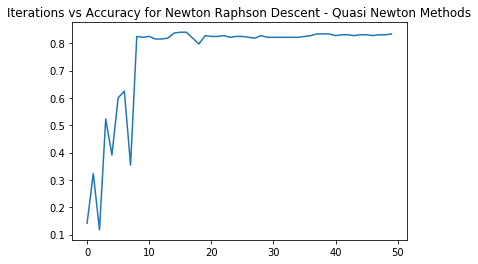

In [13]:
alpha =  0.1 # Learning rate as identified by eta-k in the above definition

n_iterations = 50
m =  x.shape[0] # number of data points
n = x.shape[1] # number of features
epsilon = 100
delta = 0.001
accu = []

# Add a bias to each of the rows (i.e. a constant)
x_b = np.c_[np.ones((m,1)),x]

# Take a random theta to begin the run
np.random.seed(13)
thetak = np.random.randn(n + 1,y.max()+1)
ck = np.identity((n+1)*(y.max()+1))

# Category to be made zero - Let us discard this for now.
#zero_cat = y.max()
#thetak[:,zero_cat] = 0

mu = calculate_mu(x_b,thetak)
gradk = gradient(mu, y_train_one_hot, x_b)
step = np.matmul(ck,gradk)

# Step is a CD x 1 Matrix. It is [C1[D1,D2..,Dn], C2[D1,D2,...,Dn]...]. Reshape the CD X 1 matrix to D X C
# Hence the reshape will be C x D will make it to unravel the results as required
# And then we need to add this as a D x C matrix to theta and hence we transpose it
thetakp1 = thetak - alpha * step.reshape(y.max()+1, n+1).T
accu = []
alp = []

for i in range(n_iterations):

    mu = calculate_mu(x_b,thetakp1)

    gradkp1 = gradient(mu, y_train_one_hot, x_b)  
    ckp1 = quasi_hess_inv(ck, gradk, gradkp1, thetak, thetakp1)
    
    step = np.matmul(ckp1, gradkp1)
    
    thetak = thetakp1
    
    # Get the length to move using backtracking line search
    alpha = backtrack_linesearch(x_b, thetakp1, y_train_one_hot)
    
    alp.append(alpha)
    
    thetakp1 = thetakp1 - alpha * step.reshape(y.max()+1, n+1).T
    
    gradk = gradkp1
    ck = ckp1
    accu.append(check_accuracy(thetakp1))

print("The alpha values:", alp)
plt.plot(range(n_iterations),accu)
plt.title('Iterations vs Accuracy for Newton Raphson Descent - Quasi Newton Methods')

#### 5. Final Accuracy

In [14]:
print("%.2f percent"%(check_accuracy(thetakp1)*100))

83.38 percent


#### 6. Comparison with Plain Vanilla Gradient Descent

You can refer to my other notebook that deals with gradient descent for full details on Gradient descent implementation for Softmax Regression. I will just mention the comparisons here.

#### 6.1. Batch Gradient Descent
* Final accuracy: 81.23%
* Alpha considered: 0.5
* Convergence achieved after: 59 iterations

#### 6.2. Stochastic Gradient Descent (Using just one data point)
* Final accuracy: 80.9%
* Nature: Keep fluctuating
* Convergence achieved after: 900 iterations
* But even after that it is not stable. Keeps moving around

#### 6.3. Mini-Batch Gradient Descent
<b>Size: 16</b>
* Final accuracy: 79.69%
* Convergence achieved after: 177 iterations
* Fluctuations are lower. Reaches some stability after 177 iterations

<b>Size: 32</b>
* Final accuracy: 79.38%
* Convergence achieved after: 125 iterations
* Fluctuations are lower. Reaches some stability after 125 iterations

#### 6.4. Newton Raphson Method (Pseudo Newton Methods & With Backtracking Linesearch)
* Final accuracy: 83.38%
* Convergence achieved after: 8 iterations
* Almost no major fluctuation in accuracy even on large number of runs

#### 6.5. Summary 
The quickness with which Newton Raphson converges is simply awesome. But computationally and memory usage wise it is horrible. Just look at the order of storage and computations we used above and it should be clear. There is a better method called L-BFGS which uses lesser memory than this Quasi-method uses now (But I am am not pursuing it further in this notebook)

<img src="./run_comparisons.png" />